<img src="../Images/DSC_Logo.png" style="width: 400px;">

# Time Series Theory in Python - Part 2: Stationary Time Series Models

This notebook provides an overview of stationary time series models, with a specific emphasis on the autoregressive moving average (ARMA) process. ARMA models facilitate intuitive interpretations of how past values and past errors influence current observations, which can inform decision-making processes. Additionally, the ARMA model serves as the foundation for more complex models, including ARIMA (which incorporates differencing for non-stationary data) and seasonal or multivariate variants such as SARIMA and VARMA. While ARMA models offer valuable tools for understanding time series behavior, it is important to recognize their limitations when dealing with complex real-world data, which may require alternative modeling approaches that account for non-linear behavior or non-stationary processes.

The notebook also outlines the general steps involved in the development of time series models. These steps include identifying an appropriate model type, estimating model parameters, fitting the selected model, testing the residuals to ensure model adequacy, and generating forecasts based on the fitted model. Notably, these methodologies are not limited to stationary models; they are also applicable to non-stationary or non-linear time series, providing a general framework for time series analysis and prediction.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
from pandas.plotting import lag_plot
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm

from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.stattools import kpss
from scipy import stats 

from PythonTsa.datadir import getdtapath
dtapath=getdtapath()

## 1. Moving Average (MA) Models

Generating MA(2) Model given by the equation:
<span style="font-size: 24px;">$$ X_t = \varepsilon_t + 0.6 \varepsilon_{t-1} - 0.3 \varepsilon_{t-2} $$</span>
where  <span style="font-size: 18px;">$ \varepsilon_t \sim \text{iid} \, N(0, 1). $</span> 

With the Python function `arma_generate_sample`, we can get samples from an autoregressive moving average (ARMA) process defined by specified parameters.


The time series displays neither trend nor seasonality and appears stationary. The significant ACF values at lags 1 and 2, along with the patterns observed in the PACF and lag plots, confirm that the time series follows the MA(2) process. The MA(2) model expresses the current value of the time series as a function of the current and previous two noise terms. The lag plot for lag 1 shows a positive relationship, while the lag plot for lag 2 suggests a weaker or negative correlation. Furthermore, the absence of discernible patterns in the lag plots for lags 3 and 4 reinforces that these lags do not significantly contribute to the current value, aligning with the typical behavior of an MA(2) process.

<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


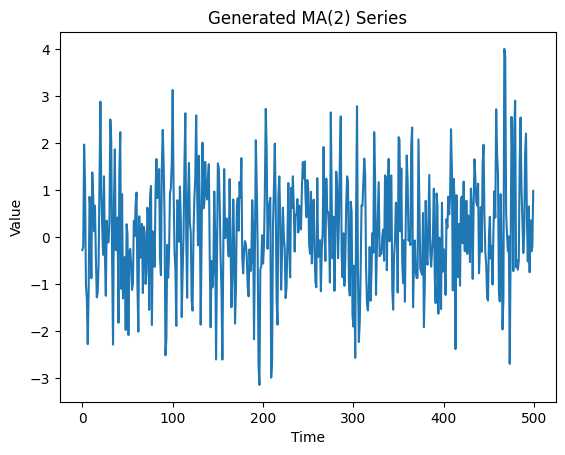

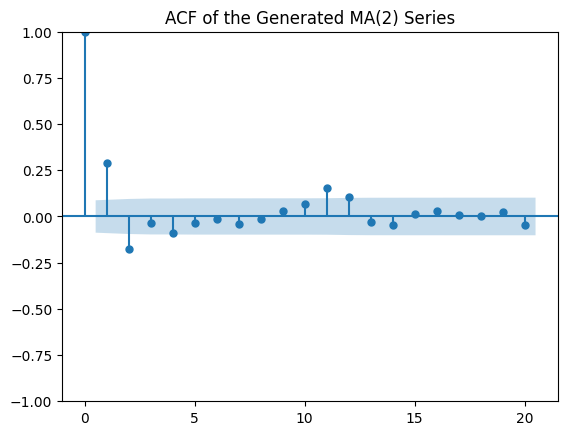

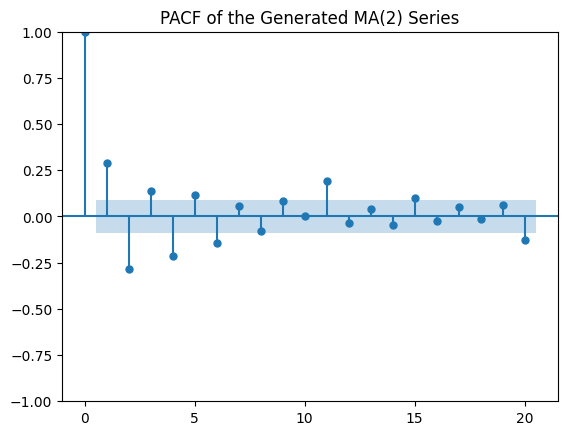

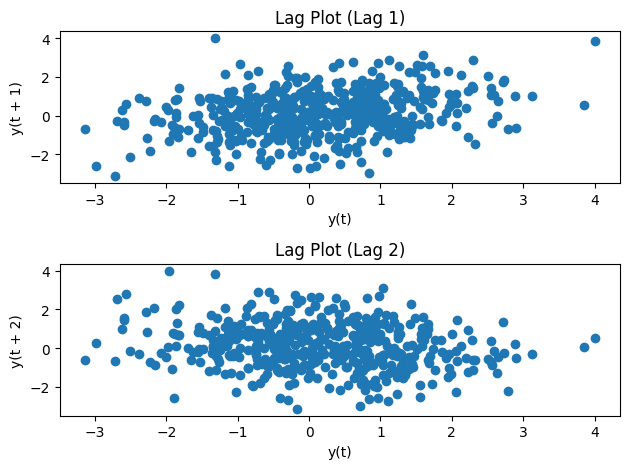

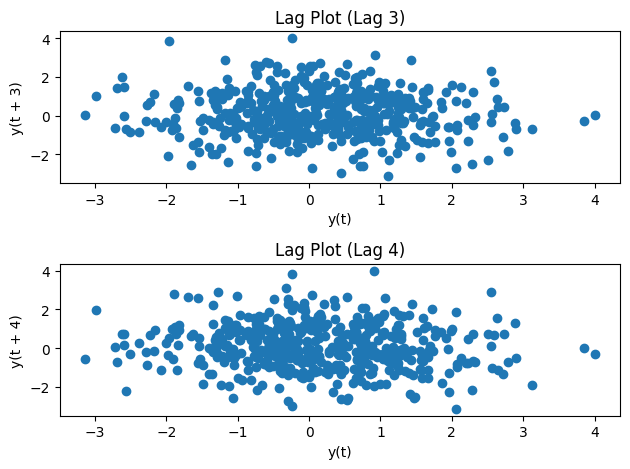

In [2]:
# Define the MA parameters
ma = np.array([1, 0.6, -0.3])  # MA coefficients

# Set the random seed for reproducibility
np.random.seed(123457)

# Generate a sample from the ARMA process
x = arma_generate_sample(ar=[1], ma=ma, nsample=500)  # AR part is set to [1] for no AR component; sample of size (length) 500

# Check the type of x (should be a numpy array)
print(type(x))  # Output: <class 'numpy.ndarray'>

# Convert x to a pandas Series
x = pd.Series(x)

# Check the type of x again (now it should be a Series)
print(type(x))  # Output: <class 'pandas.core.series.Series'>

# Plot the time series
x.plot()
plt.title('Generated MA(2) Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

# Plot ACF and PACF
plot_acf(x, lags=20)
plt.title('ACF of the Generated MA(2) Series') # we see: MA(2) is at lag 1 & 2 out of the band
plt.show()
plot_pacf(x, lags=20)
plt.title('PACF of the Generated MA(2) Series')
plt.show()

# Lag plots for lag 1 and 2
fig = plt.figure()
lag_plot(x, lag=1, ax=fig.add_subplot(211))
plt.title('Lag Plot (Lag 1)')
lag_plot(x, lag=2, ax=fig.add_subplot(212))
plt.title('Lag Plot (Lag 2)')
plt.tight_layout()
plt.show()

# Lag plots for lags 3 and 4
fig = plt.figure()
lag_plot(x, lag=3, ax=fig.add_subplot(211))
plt.title('Lag Plot (Lag 3)')
lag_plot(x, lag=4, ax=fig.add_subplot(212))
plt.title('Lag Plot (Lag 4)')
plt.tight_layout()
plt.show()

## 2. Autoregressive Models

Generating AR(2) Model given by the equation:  
<span style="font-size: 24px;">$$ X_t = 0.8 X_{t-1} - 0.3 X_{t-2} + \varepsilon_t $$</span>  

where  <span style="font-size: 18px;">$ \varepsilon_t \sim \text{iid} \, N(0, 1). $</span>

The time series shows no trend or seasonality and appears stationary. The PACF values are almost zero after lag 3, indicating that the series follows an autoregressive process, where the current observation is primarily influenced by the most recent values (two most recent values for AR(2)). The ACF shows tailing off, which is also characteristic of autoregressive processes. However, significant positive autocorrelation at lag 11 suggests that there may be more complexity in the data needing further investigation.

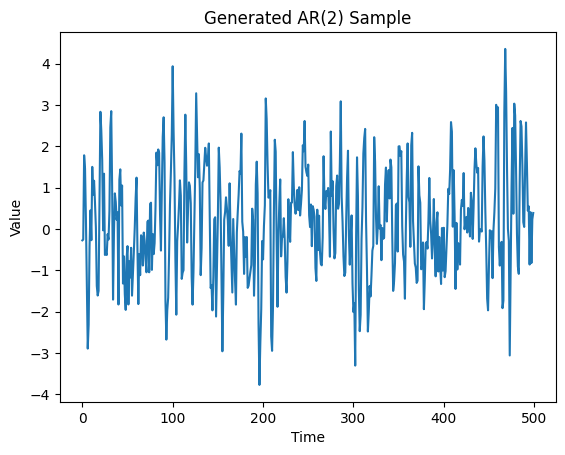

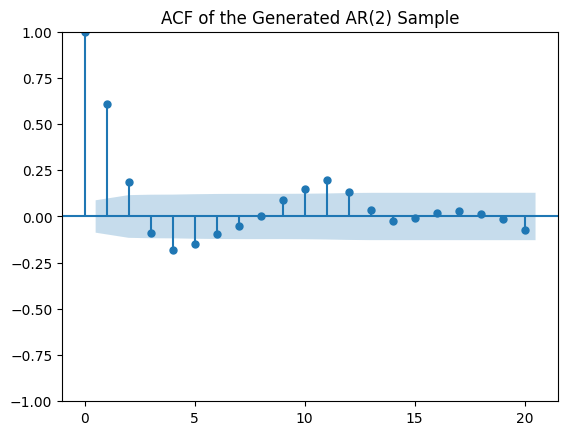

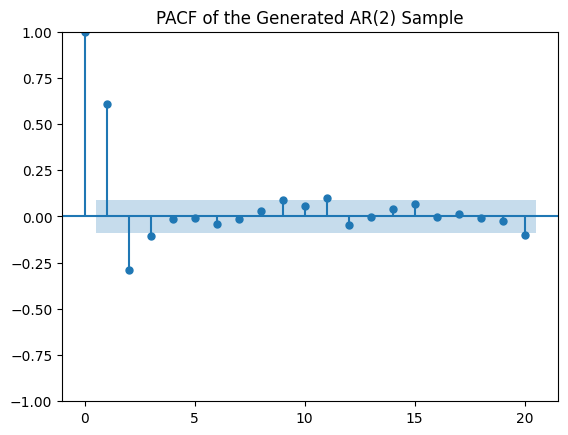

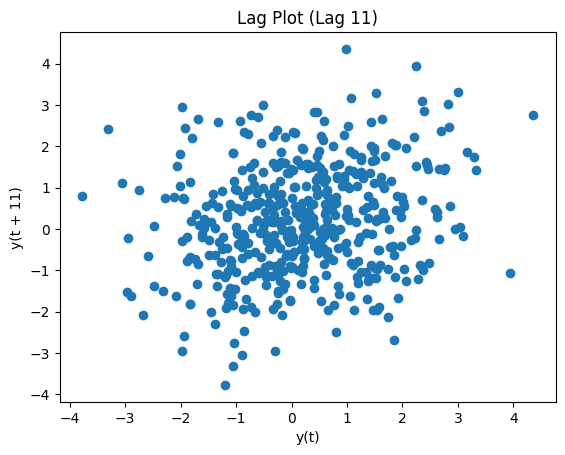

In [3]:
# Define the AR parameters (AR(2) model)
ar = np.array([1, -0.8, 0.3])  # AR coefficients

# Set the random seed for reproducibility
np.random.seed(123457)

# Generate a sample from the AR process
x = arma_generate_sample(ar=ar, ma=[1], nsample=500)  # ma=[1] means no MA part in the model; sample of size (length) 500

# Convert the generated sample to a pandas Series
x = pd.Series(x)

# Plot the time series
x.plot()
plt.title('Generated AR(2) Sample')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

# Plot ACF and PACF
plot_acf(x, lags=20)
plt.title('ACF of the Generated AR(2) Sample')
plt.show()
plot_pacf(x, lags=20)
plt.title('PACF of the Generated AR(2) Sample')
plt.show()

# Lag plot for lag 11
lag_plot(x, lag=11)
plt.title('Lag Plot (Lag 11)')
plt.show()


## 3. Autoregressive Moving Average (ARMA) Models

Consider the following ARMA(2,2) model:

<span style="font-size: 18px;">$$
X_t = 0.8 X_{t-1} - 0.6 X_{t-2} + \varepsilon_t + 0.7 \varepsilon_{t-1} + 0.4 \varepsilon_{t-2}
$$</span>

In an ARMA model, which combines both AR and MA components, the current value $X_t$ is expressed as a linear combination of its previous values **and** past error terms ($\varepsilon $). Specifically, an ARMA(p,q) model combines the features of AR(p), which captures the influence of the past values, and MA(q), which incorporates the effects of past error terms.

The generated time series is stationary and exhibits a rapid decay to zero for both the ACF and PACF. However, many ACF and PACF values remain nonzero for lags equal to or greater than 3, indicating a tailing off behavior typical of an ARMA(2,2) model.

Stationarity: True
Invertibility: True


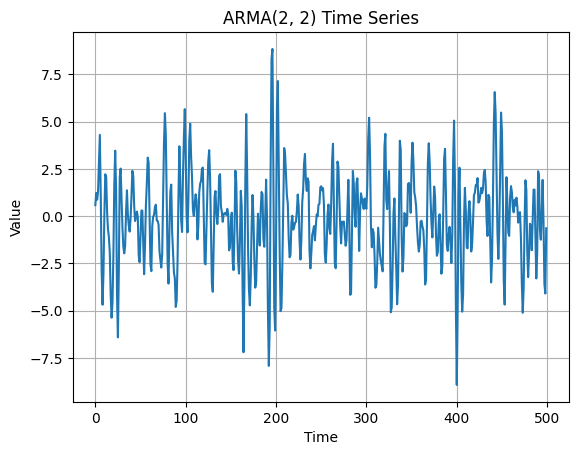

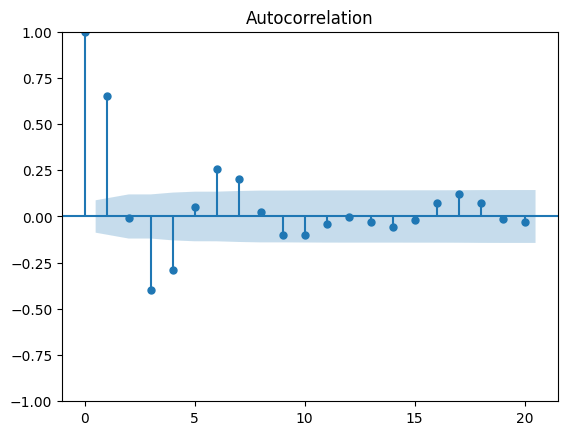

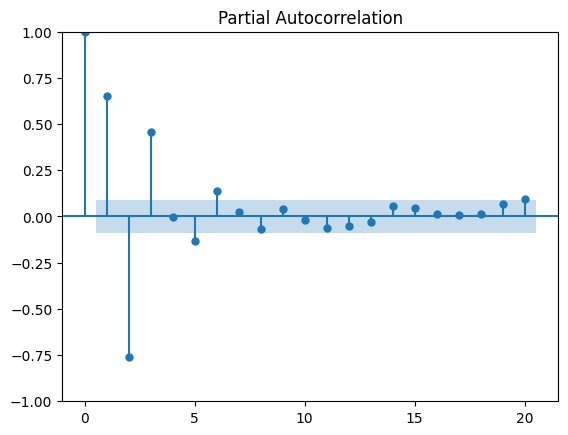

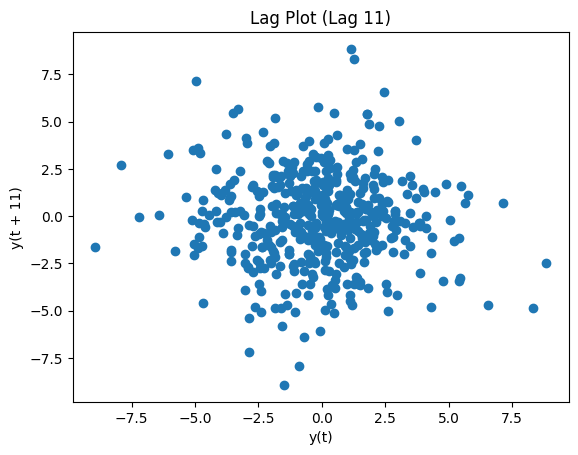

In [4]:
# Set random seed for reproducibility
np.random.seed(12357)

# Define AR and MA parameters for the ARMA model
ar = np.array([1, -0.8, 0.6])  # AR coefficients
ma = np.array([1, 0.7, 0.4])   # MA coefficients

# Create an ARMA process
arma_process = sm.tsa.ArmaProcess(ar, ma)

# Check for stationarity and invertibility
print("Stationarity:", arma_process.isstationary)  # Check if the process is stationary
print("Invertibility:", arma_process.isinvertible)  # Check if the process is invertible

# Generate a sample from the ARMA process
y = arma_generate_sample(ar=ar, ma=ma, nsample=500)
y = pd.Series(y, name='y')  # Convert the generated data to a pandas Series

# Plot the time series
plt.figure()
y.plot(title='ARMA(2, 2) Time Series', xlabel='Time', ylabel='Value')
plt.grid()
plt.show()

# Plot ACF and PACF
plot_acf(y, lags=20)
plt.show()
plot_pacf(y, lags=20)
plt.show()

# Lag plot for lag 11
lag_plot(y, lag=11)
plt.title('Lag Plot (Lag 11)')
plt.show()

### Choose model:

We will now assume that we no longer remember the source of the sample and aim to construct an ARMA(p,q) model for it. The challenge lies in determining the appropriate orders (p,q). To address this, we model various combinations of orders p and q and compare them using the metrics AIC, BIC, and HQIC. AIC (Akaike Information Criterion), BIC (Bayesian Information Criterion), and HQIC (Hannan-Quinn Information Criterion) are statistical criteria used to compare the goodness of fit of multiple models while penalizing for model complexity, helping to avoid overfitting. A smaller value indicates a better model fit relative to the complexity of the model. 

The decreasing AIC values suggest that the models are improving as we increase the complexity (i.e., higher values of q and/or p), which is expected in time series modeling. BIC and HQIC suggest (2,2), while AIC suggests a higher-order model. 

Note: 

- ARMA modeling using the `statsmodels` library is performed with the Python function ARIMA, where the differencing parameter is set to zero (i.e., order=(p,0,q)). This fits an ARMA(p,q) model to the data.

- Warnings serve as a signal that model assumptions, the fitting process, and possibly the data itself require review. It helps to ensure that the models chosen are appropriate and that the estimates produced are reliable.

In [5]:
max_p = 6 # how many past values of the series are used to predict future values
max_q = 7 # number of lagged forecast errors in the prediction equation
model_metrics = []

print("Fitting ARMA models...")

for p in range(max_p + 1):
    for q in range(max_q + 1):
        if p == 0 and q == 0:
            continue  # Skip the case where both p and q are zero
        
        try:
            model = ARIMA(y, order=(p, 0, q)).fit()  # Use ARIMA with d=0 for ARMA
            model_metrics.append((p, q, model.aic, model.bic, model.hqic))  # Store p, q, metrics
            print(f"Fitted ARIMA({p}, 0, {q}) with AIC: {model.aic}, BIC: {model.bic}, HQIC: {model.hqic}")  # Print metrics for each fitted model
        except Exception as e:
            print(f"Error fitting ARIMA({p}, 0, {q}): {e}")

# Convert model metrics to DataFrame for easier analysis
metrics_df = pd.DataFrame(model_metrics, columns=['p', 'q', 'AIC', 'BIC', 'HQIC'])

# Print model metrics
print("\nModel Metrics for Different ARMA Models:")
print(metrics_df)

# Get the best model based on the minimum AIC
if not metrics_df.empty:
    best_model = metrics_df.loc[metrics_df['AIC'].idxmin()] # choose best model based on AIC only
    print("\nBest ARMA Model (p, q, AIC):", best_model)
else:
    print("No models were fitted successfully.")

Fitting ARMA models...
Fitted ARIMA(0, 0, 1) with AIC: 1859.3623778910605, BIC: 1872.006202186327, HQIC: 1864.3237938846648


/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fitted ARIMA(0, 0, 2) with AIC: 1619.6683140821474, BIC: 1636.5267464758363, HQIC: 1626.2835354069532


/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fitted ARIMA(0, 0, 3) with AIC: 1529.4647374353817, BIC: 1550.5377779274927, HQIC: 1537.733764091389


/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fitted ARIMA(0, 0, 4) with AIC: 1531.4411001852932, BIC: 1556.7287487758263, HQIC: 1541.363932172502
Fitted ARIMA(0, 0, 5) with AIC: 1491.3057756263747, BIC: 1520.8080323153301, HQIC: 1502.882412944785
Fitted ARIMA(0, 0, 6) with AIC: 1478.012471186969, BIC: 1511.7293359743464, HQIC: 1491.2429138365806


/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fitted ARIMA(0, 0, 7) with AIC: 1479.4808524911764, BIC: 1517.412325376976, HQIC: 1494.3651004719895
Fitted ARIMA(1, 0, 0) with AIC: 2030.9478830591086, BIC: 2043.591707354375, HQIC: 2035.9092990527129
Fitted ARIMA(1, 0, 1) with AIC: 1728.3585632313336, BIC: 1745.2169956250225, HQIC: 1734.9737845561394


/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fitted ARIMA(1, 0, 2) with AIC: 1582.5271964726662, BIC: 1603.6002369647772, HQIC: 1590.7962231286735


/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitted ARIMA(1, 0, 3) with AIC: 1615.4130706367773, BIC: 1640.7007192273104, HQIC: 1625.3359026239862
Fitted ARIMA(1, 0, 4) with AIC: 1510.5492587139252, BIC: 1540.0515154028806, HQIC: 1522.1258960323355
Fitted ARIMA(1, 0, 5) with AIC: 1486.00757646757, BIC: 1519.7244412549476, HQIC: 1499.2380191171817
Fitted ARIMA(1, 0, 6) with AIC: 1479.8486127438996, BIC: 1517.7800856296992, HQIC: 1494.7328607247127
Fitted ARIMA(1, 0, 7) with AIC: 1474.9498437360107, BIC: 1517.0959247202327, HQIC: 1491.4878970480254
Fitted ARIMA(2, 0, 0) with AIC: 1594.040955065589, BIC: 1610.899387459278, HQIC: 1600.6561763903949
Fitted ARIMA(2, 0, 1) with AIC: 1511.5537167316472, BIC: 1532.6267572237582, HQIC: 1519.8227433876546
Fitted ARIMA(2, 0, 2) with AIC: 1456.824489392382, BIC: 1482.112137982915, HQIC: 1466.7473213795909
Fitted ARIMA(2, 0, 3) with AIC: 1457.629314485496, BIC: 1487.1315711744514, HQIC: 1469.2059518039064
Fitted ARIMA(2, 0, 4) with AIC: 1459.5886988013885, BIC: 1493.305563588766, HQIC: 1472.81

/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitted ARIMA(3, 0, 4) with AIC: 1461.2354641403174, BIC: 1499.166937026117, HQIC: 1476.1197121211305
Fitted ARIMA(3, 0, 5) with AIC: 1461.9120244729734, BIC: 1504.0581054571953, HQIC: 1478.450077784988
Fitted ARIMA(3, 0, 6) with AIC: 1463.796230612164, BIC: 1510.156919694808, HQIC: 1481.9880892553801
Fitted ARIMA(3, 0, 7) with AIC: 1464.7583607442139, BIC: 1515.3336579252802, HQIC: 1484.6040247186315
Fitted ARIMA(4, 0, 0) with AIC: 1477.1142018105647, BIC: 1502.4018504010978, HQIC: 1487.0370337977736
Fitted ARIMA(4, 0, 1) with AIC: 1475.1724363891867, BIC: 1504.6746930781421, HQIC: 1486.749073707597


/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fitted ARIMA(4, 0, 2) with AIC: 1459.6748029618088, BIC: 1493.3916677491864, HQIC: 1472.9052456114205
Fitted ARIMA(4, 0, 3) with AIC: 1456.7181079413317, BIC: 1494.6495808271313, HQIC: 1471.6023559221449


/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fitted ARIMA(4, 0, 4) with AIC: 1462.4802035886619, BIC: 1504.6262845728838, HQIC: 1479.0182569006765


/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitted ARIMA(4, 0, 5) with AIC: 1455.9526886315778, BIC: 1502.3133777142218, HQIC: 1474.144547274794


/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitted ARIMA(4, 0, 6) with AIC: 1465.896439086519, BIC: 1516.4717362675854, HQIC: 1485.7421030609366


/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitted ARIMA(4, 0, 7) with AIC: 1460.3206722830807, BIC: 1515.1105775625692, HQIC: 1481.8201415886997
Fitted ARIMA(5, 0, 0) with AIC: 1469.4561773448504, BIC: 1498.9584340338058, HQIC: 1481.0328146632608
Fitted ARIMA(5, 0, 1) with AIC: 1467.2799807289316, BIC: 1500.9968455163091, HQIC: 1480.5104233785432


/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fitted ARIMA(5, 0, 2) with AIC: 1460.7943481393597, BIC: 1498.7258210251593, HQIC: 1475.6785961201729
Fitted ARIMA(5, 0, 3) with AIC: 1462.2962747750155, BIC: 1504.4423557592374, HQIC: 1478.8343280870301


/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fitted ARIMA(5, 0, 4) with AIC: 1464.2840750790465, BIC: 1510.6447641616905, HQIC: 1482.4759337222627


/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitted ARIMA(5, 0, 5) with AIC: 1466.1331584612083, BIC: 1516.7084556422747, HQIC: 1485.978822435626


/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitted ARIMA(5, 0, 6) with AIC: 1463.9483313387436, BIC: 1518.7382366182321, HQIC: 1485.4478006443626


/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitted ARIMA(5, 0, 7) with AIC: 1469.6727990091044, BIC: 1528.677312387015, HQIC: 1492.826073645925
Fitted ARIMA(6, 0, 0) with AIC: 1462.478065688896, BIC: 1496.1949304762736, HQIC: 1475.7085083385077
Fitted ARIMA(6, 0, 1) with AIC: 1464.144520453821, BIC: 1502.0759933396207, HQIC: 1479.0287684346342
Fitted ARIMA(6, 0, 2) with AIC: 1462.6379306861124, BIC: 1504.7840116703344, HQIC: 1479.175983998127
Fitted ARIMA(6, 0, 3) with AIC: 1464.2910785304196, BIC: 1510.6517676130636, HQIC: 1482.4829371736357


/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitted ARIMA(6, 0, 4) with AIC: 1466.1199682359118, BIC: 1516.6952654169781, HQIC: 1485.9656322103294


/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitted ARIMA(6, 0, 5) with AIC: 1467.7277599272427, BIC: 1522.5176652067312, HQIC: 1489.2272292328616


/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitted ARIMA(6, 0, 6) with AIC: 1462.5679370731573, BIC: 1521.5724504510679, HQIC: 1485.7212117099778


/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitted ARIMA(6, 0, 7) with AIC: 1466.5577761137943, BIC: 1529.7768975901272, HQIC: 1491.3648560818162

Model Metrics for Different ARMA Models:
    p  q          AIC          BIC         HQIC
0   0  1  1859.362378  1872.006202  1864.323794
1   0  2  1619.668314  1636.526746  1626.283535
2   0  3  1529.464737  1550.537778  1537.733764
3   0  4  1531.441100  1556.728749  1541.363932
4   0  5  1491.305776  1520.808032  1502.882413
5   0  6  1478.012471  1511.729336  1491.242914
6   0  7  1479.480852  1517.412325  1494.365100
7   1  0  2030.947883  2043.591707  2035.909299
8   1  1  1728.358563  1745.216996  1734.973785
9   1  2  1582.527196  1603.600237  1590.796223
10  1  3  1615.413071  1640.700719  1625.335903
11  1  4  1510.549259  1540.051515  1522.125896
12  1  5  1486.007576  1519.724441  1499.238019
13  1  6  1479.848613  1517.780086  1494.732861
14  1  7  1474.949844  1517.095925  1491.487897
15  2  0  1594.040955  1610.899387  1600.656176
16  2  1  1511.553717  1532.626757  1519

The function `sm.tsa.arma_order_select_ic()` is a built-in model selection tool in the `statsmodels` library that automates the process of determining the best ARMA model orders based on specified criteria (AIC, BIC, HQIC):

In [6]:
inf = sm.tsa.arma_order_select_ic(y, max_ar=6, max_ma=7, ic=['aic', 'bic', 'hqic'], trend='c') # for statsmodels 0.13.0 and later, trend=’n’

/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: Conver

In [7]:
print("Best AR term (p for minimum AIC):", inf.aic_min_order[0])
print("Best MA term (q for minimum AIC):", inf.aic_min_order[1])

print("Best AR term (p for minimum BIC):", inf.bic_min_order[0])
print("Best MA term (q for minimum BIC):", inf.bic_min_order[1])

print("Best AR term (p for minimum HQIC):", inf.hqic_min_order[0])
print("Best MA term (q for minimum HQIC):", inf.hqic_min_order[1])

Best AR term (p for minimum AIC): 4
Best MA term (q for minimum AIC): 5
Best AR term (p for minimum BIC): 2
Best MA term (q for minimum BIC): 2
Best AR term (p for minimum HQIC): 2
Best MA term (q for minimum HQIC): 2


### Fit model:

Based on the results from the model testing process and the understanding that the sample originates from an ARMA(2, 2) model, we proceed to fit this model to the data, analyze the fitted model and the residuals. 

The summary statistics reveal key characteristics of the fitted model, including the estimated coefficients, standard errors, and the goodness-of-fit measures. Analyzing the residuals is crucial for diagnosing how well the chosen model fits the data and testing for white noise residuals. If the residuals exhibit significant autocorrelation in the ACF/PACF plots or show significant deviations from normality, it may indicate that the model is not properly specified or suitable for the data.

The model appears to fit the data well. The residuals from the model exhibit no significant autocorrelation or evidence of non-normality (hence, behave like those of white noise), suggesting that the model is appropriately specified for the time series data.

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  500
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -722.842
Date:                Wed, 06 Nov 2024   AIC                           1455.684
Time:                        18:01:43   BIC                           1476.757
Sample:                             0   HQIC                          1463.953
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8108      0.043     18.709      0.000       0.726       0.896
ar.L2         -0.6313      0.039    -16.186      0.000      -0.708      -0.555
ma.L1          0.7085      0.056     12.706      0.0

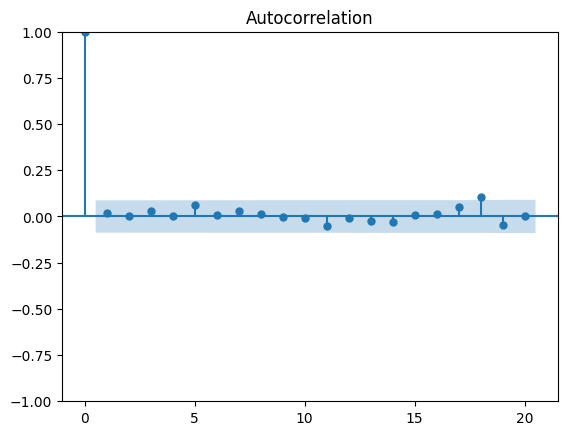

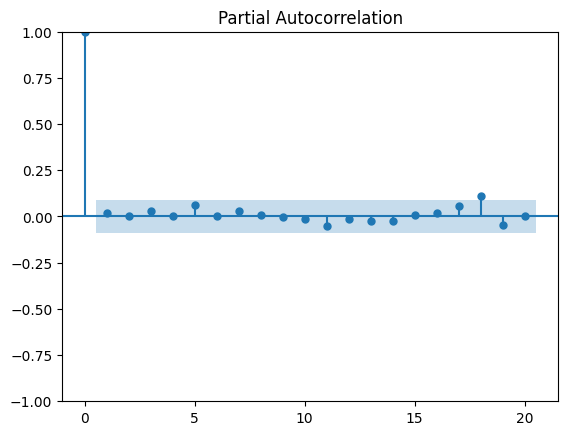

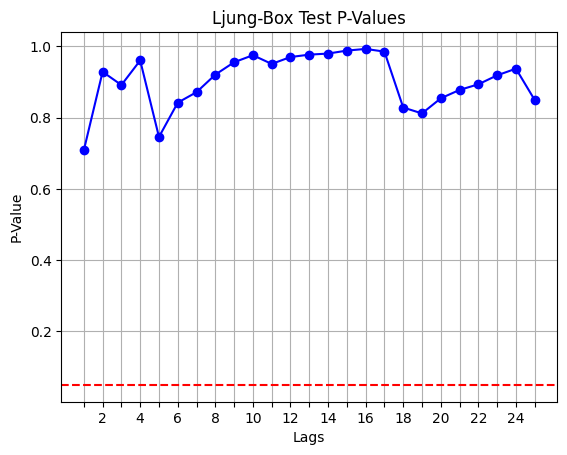

Normality test result: NormaltestResult(statistic=np.float64(0.4804604716101055), pvalue=np.float64(0.7864467720150756))


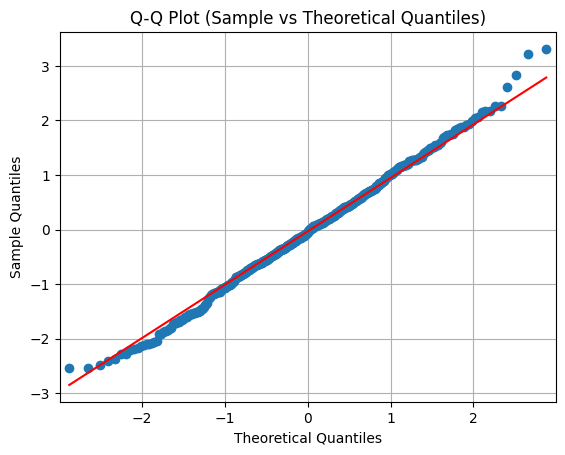

In [8]:
# Fit the ARMA(2,2) model
arma22 = ARIMA(y, order=(2,0,2), trend='n').fit()
print(arma22.summary())

# Analyze the residuals
resid22 = arma22.resid

# Plot ACF and PACF of the residuals
plot_acf(resid22, lags=20)
plt.show()
plot_pacf(resid22, lags=20)
plt.show()

# Perform the Ljung-Box test for residuals
    # Calculate Ljung-Box test statistics and p-values
ljung_box_results = acorr_ljungbox(resid22, lags=25, return_df=True)
    # Create a plot for the p-values
plt.figure()
plt.plot(ljung_box_results['lb_pvalue'], marker='o', linestyle='-', color='b')
plt.axhline(y=0.05, color='r', linestyle='--')  # 5% significance level
plt.title('Ljung-Box Test P-Values')
plt.xlabel('Lags')
plt.ylabel('P-Value')
plt.xticks(np.arange(0, 26, 1))
plt.xticks(ljung_box_results.index)  # Set x-ticks to all lags
plt.gca().set_xticklabels([str(int(x)) if x % 2 == 0 else '' for x in ljung_box_results.index])
plt.grid()
plt.show()

# Q-Q plot
plt.figure()
sm.qqplot(resid22, line='q', ax=plt.gca())
plt.title('Q-Q Plot (Sample vs Theoretical Quantiles)')
plt.grid()

# Perform the normality test on residuals
normaltest_result = stats.normaltest(resid22)
print("Normality test result:", normaltest_result)

### Predict model:

For the specified time range, both the initial part of the out-of-sample forecasts and the in-sample predictions appear satisfactory. It is a common occurrence in ARIMA time series forecasting for predictions made further into the future to converge toward a constant value, typically the mean of the historical data. Additionally, the increasing uncertainty of predictions is evident in the wider confidence intervals for more distant out-of-sample forecasts compared to those for in-sample predictions or closer out-of-sample predictions, as the model has less information when forecasting beyond the observed data.

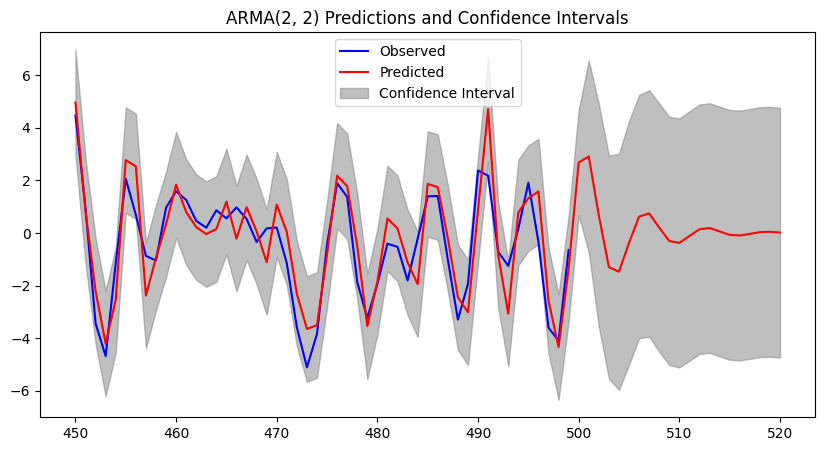

In [9]:
# Get predictions for a specified range (start=450, end=520)
pred = arma22.get_prediction(start=450, end=520)
predicts = pred.predicted_mean
predconf = pred.conf_int()

# Combine observed data, predictions, and confidence intervals into a DataFrame
predframe = pd.concat([y[450:], predicts, predconf], axis=1)
predframe.columns = ['Observed', 'Predicted', 'Lower CI', 'Upper CI']

# Plot observed, predicted, and confidence intervals
plt.figure(figsize=(10, 5))
plt.plot(predframe['Observed'], label='Observed', color='blue')
plt.plot(predframe['Predicted'], label='Predicted', color='red')
plt.fill_between(predframe.index, predframe['Lower CI'], predframe['Upper CI'], color='gray', alpha=0.5, label='Confidence Interval')
plt.title('ARMA(2, 2) Predictions and Confidence Intervals')
plt.legend()
plt.show()

Forecasts are not so good although the resulting model fits well.

### **Example 1: The NAO Index Since January 1950**

The time series is the monthly mean North Atlantic Oscillation (NAO) index since January 1950. The series appears stationary (compare notebook C1). We will treat the NAO series as originating from an ARMA process and aim to build an ARMA(p,q) model. Both AR and MA components could be viable options; however, the evident cutoff in the PACF plot after lag 1 suggests that an autoregressive process may be more appropriate.

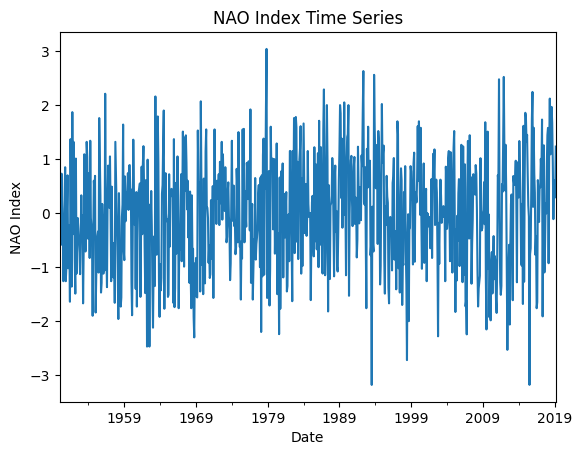

<Figure size 640x480 with 0 Axes>

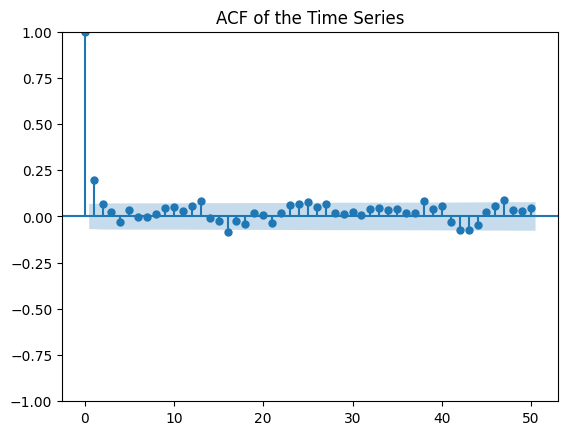

<Figure size 640x480 with 0 Axes>

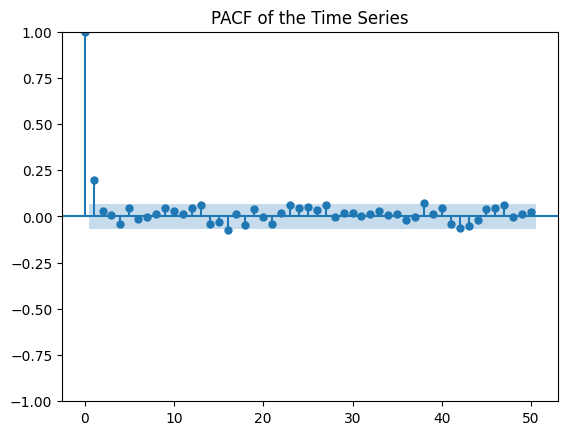

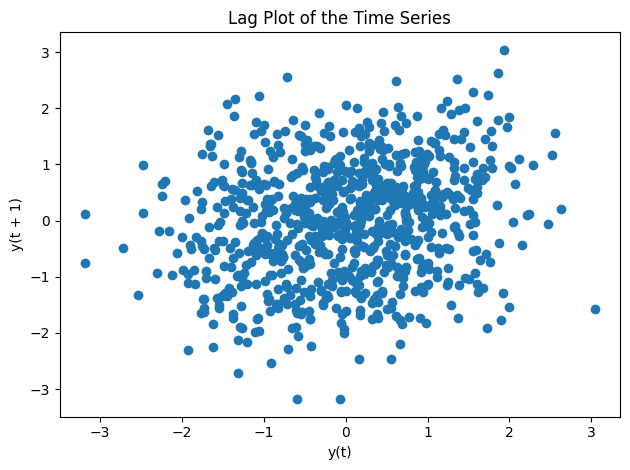

In [10]:
# Load the NAO dataset
nao = pd.read_csv(dtapath + 'nao.csv', header=0)

# Create a time index
timeindex = pd.date_range('1950-01', periods=len(nao), freq='ME')
nao.index = timeindex

# Extract NAO index as a Series
naots = nao['index']  # Ensure 'index' corresponds to the correct column name

# Plot the NAO index time series
naots.plot(title='NAO Index Time Series', xlabel='Date', ylabel='NAO Index')
plt.show()

# Plot ACF
fig = plt.figure()
plot_acf(naots, lags=50)
plt.title("ACF of the Time Series")
plt.show()

# Plot PACF
fig = plt.figure()
plot_pacf(naots, lags=50)
plt.title("PACF of the Time Series")
plt.show()

# Plot Lag Plot
lag_plot(naots)
plt.title('Lag Plot of the Time Series')
plt.tight_layout()
plt.show()

**Exercise:** Fit and evaluate suitable models for the time series and select the best model based on AIC, BIC, and HQIC criteria.

In [11]:
inf = sm.tsa.arma_order_select_ic(naots, max_ar=2, max_ma=2, ic=['aic', 'bic', 'hqic'], trend='c')

/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [12]:
print("Best AR term (p for minimum AIC):", inf.aic_min_order[0])
print("Best MA term (q for minimum AIC):", inf.aic_min_order[1])

print("Best AR term (p for minimum BIC):", inf.bic_min_order[0])
print("Best MA term (q for minimum BIC):", inf.bic_min_order[1])

print("Best AR term (p for minimum HQIC):", inf.hqic_min_order[0])
print("Best MA term (q for minimum HQIC):", inf.hqic_min_order[1])

Best AR term (p for minimum AIC): 1
Best MA term (q for minimum AIC): 0
Best AR term (p for minimum BIC): 1
Best MA term (q for minimum BIC): 0
Best AR term (p for minimum HQIC): 1
Best MA term (q for minimum HQIC): 0


**Exercise:** Fit the best model. What is the value of the AR coefficient?

In [13]:
ar1 = ARIMA(naots, order=(1, 0, 0)).fit()
print(ar1.summary())

                               SARIMAX Results                                
Dep. Variable:                  index   No. Observations:                  831
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1176.007
Date:                Wed, 06 Nov 2024   AIC                           2358.013
Time:                        18:01:48   BIC                           2372.181
Sample:                    01-31-1950   HQIC                          2363.446
                         - 03-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.043      0.092      0.927      -0.081       0.089
ar.L1          0.1996      0.033      6.041      0.000       0.135       0.264
sigma2         0.9924      0.054     18.443      0.0

The resulting model is: <span style="font-size: 24px;">$$ X_t = 0.1996 X_{t-1}  + \varepsilon_t $$</span>  

**Exercise:** Analyze the residuals from the fitted ARIMA model to assess whether the model fits well.

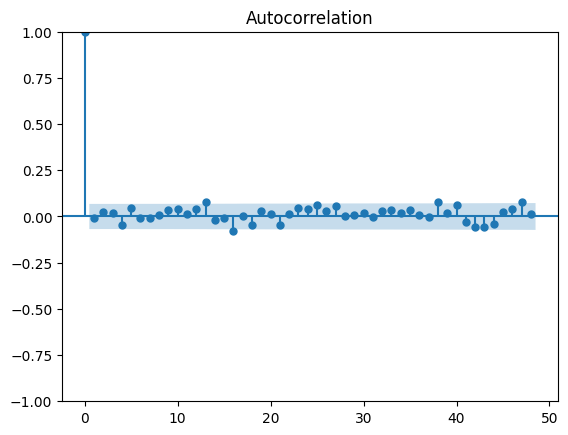

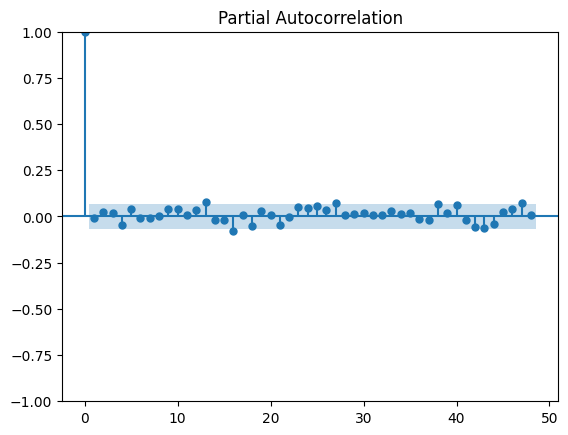

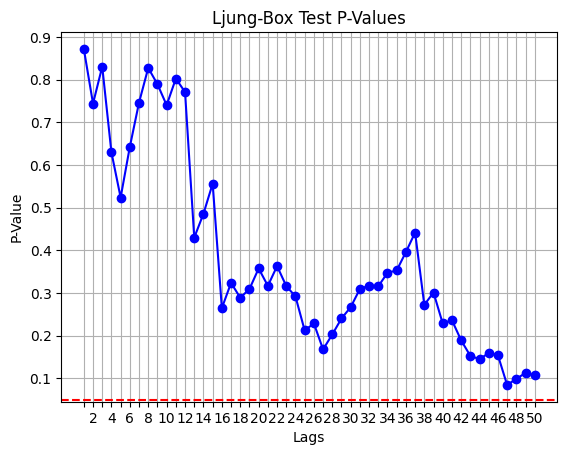

Normality test result: NormaltestResult(statistic=np.float64(7.451316542116733), pvalue=np.float64(0.02409723269388606))


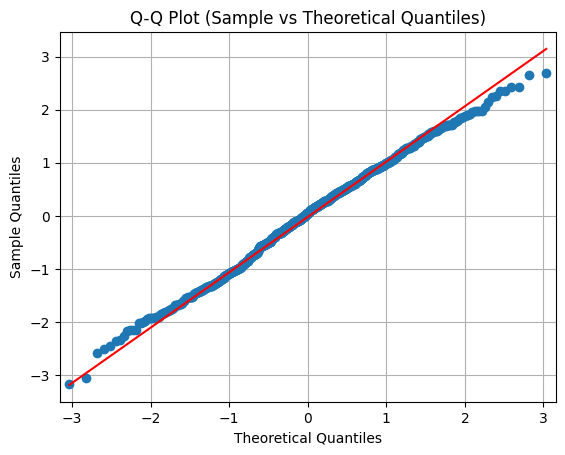

In [14]:
# Analyze residuals from the ARIMA model
resid1 = ar1.resid

# Plot ACF and PACF of the residuals
plot_acf(resid1, lags=48)
plt.show()
plot_pacf(resid1, lags=48)
plt.show()

# Perform the Ljung-Box test for residuals
    # Calculate Ljung-Box test statistics and p-values
ljung_box_results = acorr_ljungbox(resid1, lags=50, return_df=True)
    # Create a plot for the p-values
plt.figure()
plt.plot(ljung_box_results['lb_pvalue'], marker='o', linestyle='-', color='b')
plt.axhline(y=0.05, color='r', linestyle='--')  # 5% significance level
plt.title('Ljung-Box Test P-Values')
plt.xlabel('Lags')
plt.ylabel('P-Value')
plt.xticks(np.arange(0, 31, 1))
plt.grid()
plt.xticks(ljung_box_results.index)  # Set x-ticks to all lags
plt.gca().set_xticklabels([str(int(x)) if x % 2 == 0 else '' for x in ljung_box_results.index])
plt.show()

# Q-Q plot
plt.figure()
sm.qqplot(resid1, line='q', ax=plt.gca())
plt.title('Q-Q Plot (Sample vs Theoretical Quantiles)')
plt.grid()

# Perform the normality test on residuals
normaltest_result = stats.normaltest(resid1)
print("Normality test result:", normaltest_result)

The model seems to be sufficient for the NAO time series.

**Exercise:** Use the fitted model for out-of-sample and in-sample predictions from April 2010 to December 2019. Plot the predictions and confidence intervals.

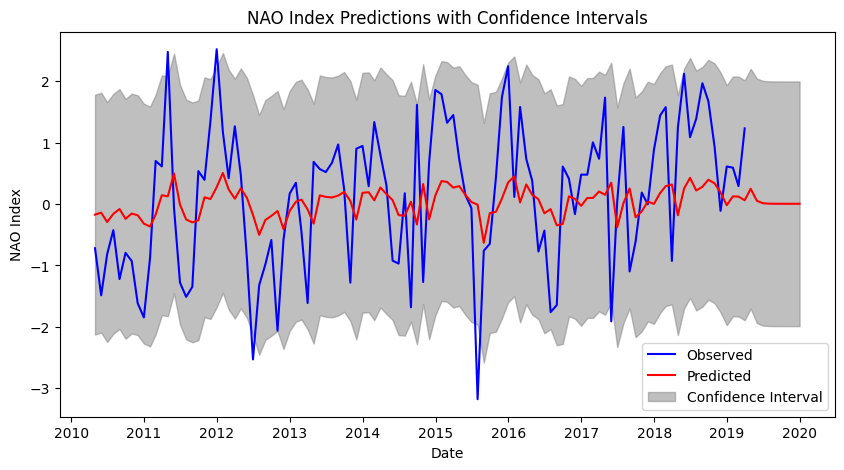

In [15]:
# Get predictions and confidence intervals
pred = ar1.get_prediction(start='2010-04', end='2019-12')
predicts = pred.predicted_mean
predconf = pred.conf_int()

# Create a DataFrame to hold the predictions and confidence intervals
predframe = pd.concat([naots['2010-04':], predicts, predconf], axis=1)
predframe.columns = ['Observed', 'Predicted', 'Lower CI', 'Upper CI']

# Plot the predictions and confidence intervals
plt.figure(figsize=(10, 5))
plt.plot(predframe['Observed'], label='Observed', color='blue')
plt.plot(predframe['Predicted'], label='Predicted', color='red')
plt.fill_between(predframe.index, predframe['Lower CI'], predframe['Upper CI'], color='gray', alpha=0.5, label='Confidence Interval')
plt.title('NAO Index Predictions with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('NAO Index')
plt.legend()
plt.show()

The predictions are not very good, despite the model residuals exhibiting white noise behavior. This may indicate model mis-specification, insufficient complexity, data quality issues, overfitting, or undetected violations of stationarity and normality assumptions of the residuals.

## 4. Stationarity Test and Differencing

One limitation of ARMA models is the stationarity condition. In many real-world time series, data can be thought of as being composed of two components: a non-stationary trend component and a zero-mean stationary component. Several strategies exist to achieve stationarity in a non-stationary time series, including differencing, detrending/decompostion and smoothing (see also notebook C3). Here, we demonstrate the differencing technique to stationarize time series. Statistical tests like the KPSS (Kwiatkowski-Phillips-Schmidt-Shin) test can be employed to assess the stationarity of a time series. In the `statsmodels.tsa.stattools` module, the function `kpss` performs the KPSS stationarity test, where the argument `regression='c'` indicates that the test is assessing the stationarity of a time series without a clear trend or obvious seasonality.

### **Example 2: Global Annual Mean Surface Air Temperature Changes Series (1880-1985)**

The time series dataset contains global mean surface air temperature changes from 1880 to 1985, as reported by Hansen and Lebedeff (1987). The temperature changes indicated in the study are relative to the average global mean surface air temperature derived from the baseline period of 1951-1980. The frequency of the time series is annual, meaning that seasonal variations in the annual cycle are not included. The trend in the time series illustrates the global warming. We apply the first difference to the time series to remove the trend and make it stationary (tested with KPSS).

/tmp/ipykernel_661/1292898957.py:5: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  dates = pd.date_range('1880-12', periods=len(tep), freq='A-DEC')


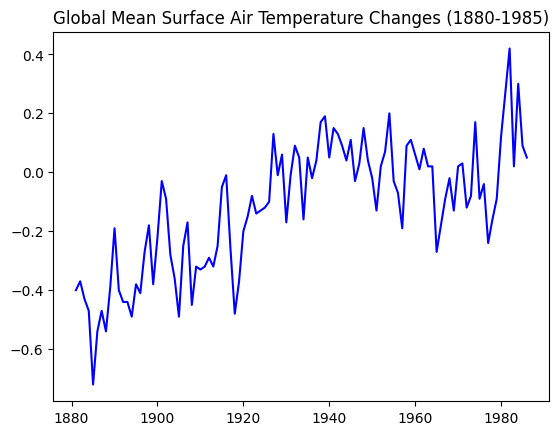

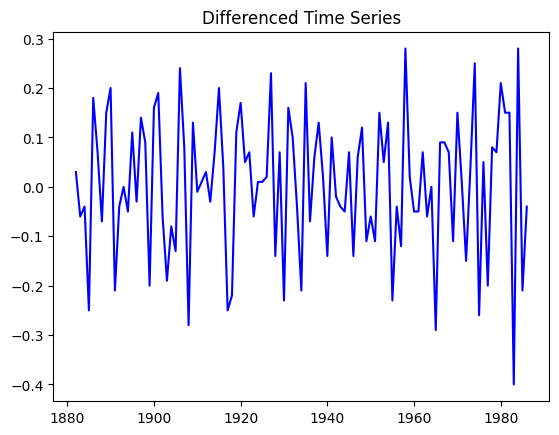

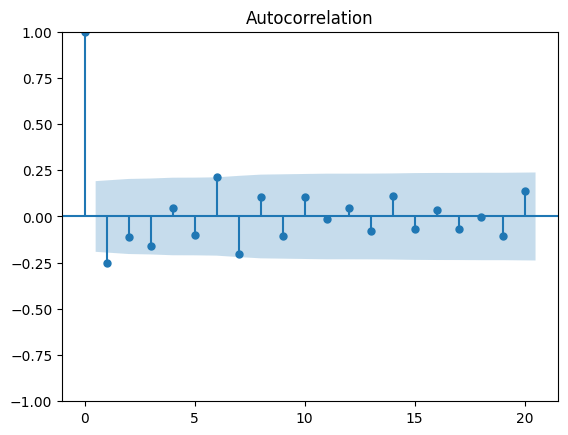

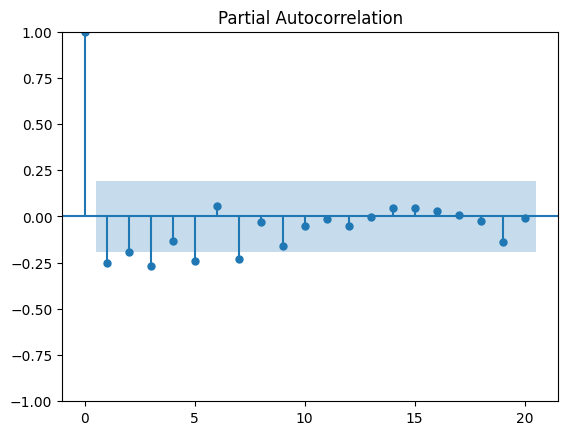

KPSS Statistic: 0.08259101825264831
p-value: 0.1
Lags: 12
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The series is likely stationary.


/tmp/ipykernel_661/1292898957.py:31: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, p_value, lags, crit_values = kpss(dtepts, regression='c', nlags='auto')


In [16]:
# Load the dataset
tep = pd.read_csv(dtapath + 'Global mean surface air temp changes 1880-1985.csv', header=None)

# Create a date index
dates = pd.date_range('1880-12', periods=len(tep), freq='A-DEC')
tep.index = dates
tepts = pd.Series(tep[0], name='tep')

# Plot the original time series
plt.plot(tepts, color='b')
plt.title('Global Mean Surface Air Temperature Changes (1880-1985)')
plt.show()

# Differencing the time series
dtepts = tepts.diff(1)
dtepts = dtepts.dropna()
dtepts.name = 'dtep'

# Plot the differenced time series
plt.plot(dtepts, color='b')
plt.title('Differenced Time Series')
plt.show()

# Plot ACF and PACF
plot_acf(dtepts, lags=20)
plt.show()
plot_pacf(dtepts, lags=20)
plt.show()

# KPSS test for stationarity
kpss_stat, p_value, lags, crit_values = kpss(dtepts, regression='c', nlags='auto')

# Output the results of the KPSS test
print(f'KPSS Statistic: {kpss_stat}')
print(f'p-value: {p_value}')
print(f'Lags: {lags}')
print('Critical Values:', crit_values)
if p_value < 0.05:
    print("The series is likely non-stationary.")
else:
    print("The series is likely stationary.")

### **Example 3: Chinese Quarterly GDP**

In notebook C1, we found that the Chinese Quarterly GDP time series has time series has both trend and seasonality. Since it is the quarterly data, the number of seasons is 4 naturally. We therefore seasonally difference it with a lag of 4. After applying seasonal differencing with a lag of 4, we plot the seasonally differenced series to visualize the effects of removing seasonality. This transformation helped highlight trends without seasonal noise. Next, we performed a first difference on the seasonally differenced series to eliminate any remaining trend components. We then plotted this first differenced series and examine its ACF and PACF to assess the correlation structure, guiding our ARIMA model selection. We also conduct the KPSS test for stationarity.

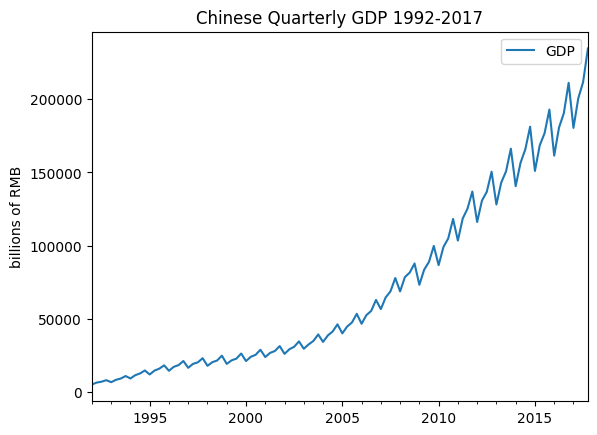

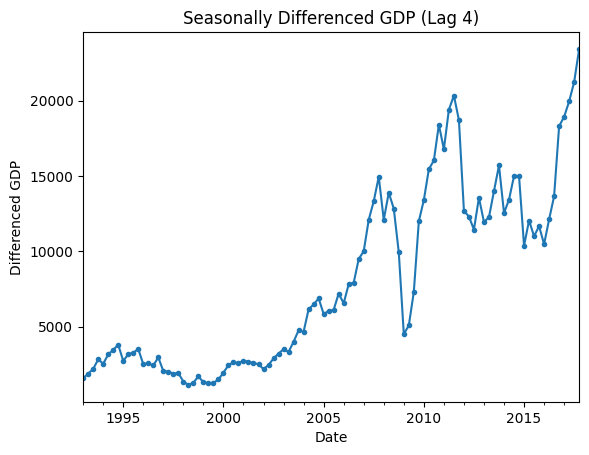

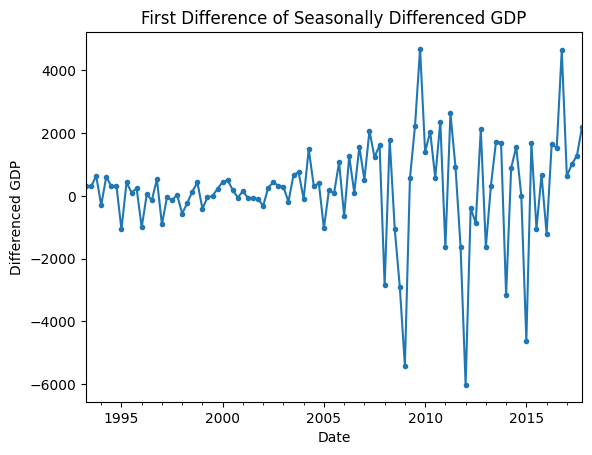

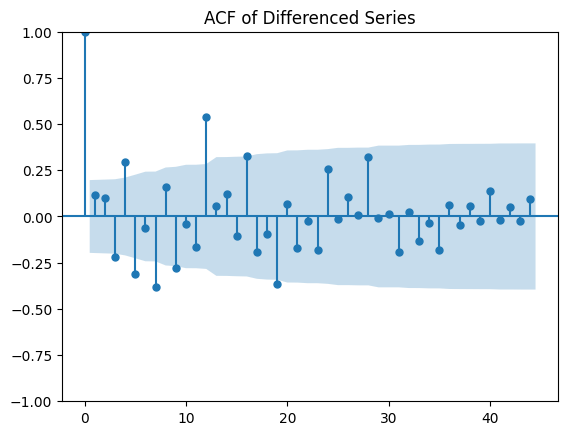

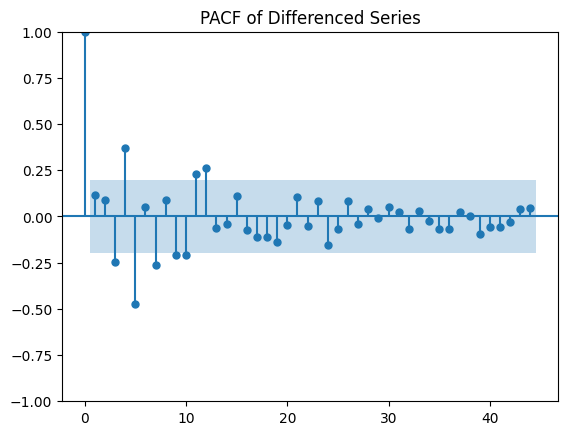

KPSS Statistic: 0.10664288385692093
p-value: 0.1
Lags: 3
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The series is likely stationary.


/tmp/ipykernel_661/3033933428.py:48: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, p_value, lags, crit_values = kpss(d1dx, regression='c', nlags='auto')


In [17]:
# Load the data
x = pd.read_csv(dtapath + 'gdpquarterlychina1992.1-2017.4.csv',header=0)
dates = pd.date_range(start='1992',periods=len(x),freq='QE')
x.index=dates

# Plot the original time series
x.plot()
plt.title('Chinese Quarterly GDP 1992-2017')
plt.ylabel('billions of RMB')
plt.show()

# Create a date range starting from 1992 with quarterly frequency
dates = pd.date_range(start='1992', periods=len(x), freq='QE')
x.index = dates

# Create a time series from the 'GDP' column
x = pd.Series(x['GDP'])

# Seasonal differencing with lag 4
dx = x.diff(4).dropna()

# Plot the seasonally differenced series
dx.plot(marker='o', ms=3)  # ms refers to marker size
plt.title('Seasonally Differenced GDP (Lag 4)')
plt.xlabel('Date')
plt.ylabel('Differenced GDP')
plt.show()

# First differencing the seasonally differenced series
d1dx = dx.diff(1).dropna()

# Plot the first difference of the seasonally differenced series
d1dx.plot(marker='o', ms=3)
plt.title('First Difference of Seasonally Differenced GDP')
plt.xlabel('Date')
plt.ylabel('Differenced GDP')
plt.show()

# Plot ACF and PACF for the first difference of seasonally differenced series
plot_acf(d1dx, lags=44)
plt.title('ACF of Differenced Series')
plt.show()
plot_pacf(d1dx, lags=44)
plt.title('PACF of Differenced Series')
plt.show()

# KPSS test for stationarity
kpss_stat, p_value, lags, crit_values = kpss(d1dx, regression='c', nlags='auto')

# Output the results of the KPSS test
print(f'KPSS Statistic: {kpss_stat}')
print(f'p-value: {p_value}')
print(f'Lags: {lags}')
print('Critical Values:', crit_values)
if p_value < 0.05:
    print("The series is likely non-stationary.")
else:
    print("The series is likely stationary.")

### **Example 1 [continued]: The NAO Index Since January 1950**

**Exercise:** Conduct the KPSS test for stationarity on the NAO data (variable 'naots') with a maximum of 50 lags.

In [18]:
# KPSS test for stationarity
kpss_stat, p_value, lags, crit_values = kpss(naots, regression='c', nlags=50)

# Output the results of the KPSS test
print(f'KPSS Statistic: {kpss_stat}')
print(f'p-value: {p_value}')
print(f'Lags: {lags}')
print('Critical Values:', crit_values)
if p_value < 0.05:
    print("The series is likely non-stationary.")
else:
    print("The series is likely stationary.")

KPSS Statistic: 0.3561836394749189
p-value: 0.09604153470908669
Lags: 50
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The series is likely stationary.


The p-value of 0.096 indicates that the NAO Index time series exhibits stationarity, suggesting that applying an ARMA model is appropriate.

## 5. Autoregressive Integrated Moving Average (ARIMA) Models

ARIMA incorporates the concept of ARMA applied to a differenced series.

### **Example 2 [continued]: Global Annual Mean Surface Air Temperature Changes Series (1880-1985)**

### Choose model:

In [19]:
inf = sm.tsa.arma_order_select_ic(dtepts, max_ar=3, max_ma=3, ic=['aic', 'bic', 'hqic'], trend='c')

/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: Conver

In [20]:
print("Best AR term (p for minimum AIC):", inf.aic_min_order[0])
print("Best MA term (q for minimum AIC):", inf.aic_min_order[1])

print("Best AR term (p for minimum BIC):", inf.bic_min_order[0])
print("Best MA term (q for minimum BIC):", inf.bic_min_order[1])

print("Best AR term (p for minimum HQIC):", inf.hqic_min_order[0])
print("Best MA term (q for minimum HQIC):", inf.hqic_min_order[1])

Best AR term (p for minimum AIC): 1
Best MA term (q for minimum AIC): 3
Best AR term (p for minimum BIC): 1
Best MA term (q for minimum BIC): 1
Best AR term (p for minimum HQIC): 1
Best MA term (q for minimum HQIC): 3


AIC and HQIC derive (p,q) = (1,3) and BIC derives (p,q) = (1,1). We choose to fit and predict the ARMA(1,1) first.

### Fit model:

                               SARIMAX Results                                
Dep. Variable:                   dtep   No. Observations:                  105
Model:                 ARIMA(1, 0, 1)   Log Likelihood                  69.356
Date:                Wed, 06 Nov 2024   AIC                           -130.713
Time:                        18:01:56   BIC                           -120.097
Sample:                    12-31-1881   HQIC                          -126.411
                         - 12-31-1985                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0053      0.003      2.121      0.034       0.000       0.010
ar.L1          0.3925      0.107      3.683      0.000       0.184       0.601
ma.L1         -0.8876      0.061    -14.515      0.0

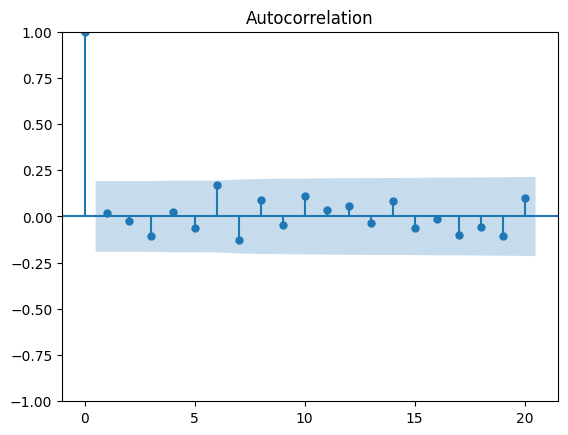

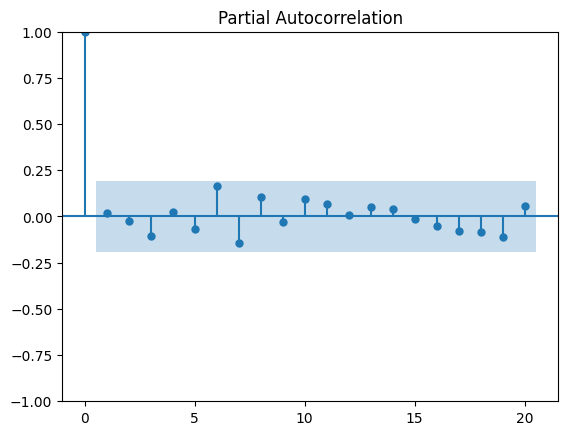

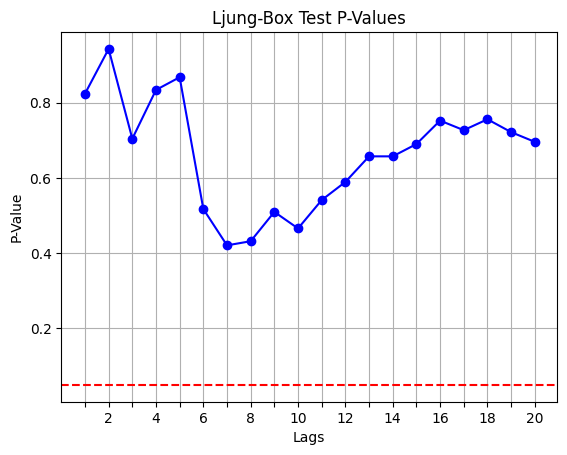

Normality test result: NormaltestResult(statistic=np.float64(0.21120226595381578), pvalue=np.float64(0.8997834704642494))


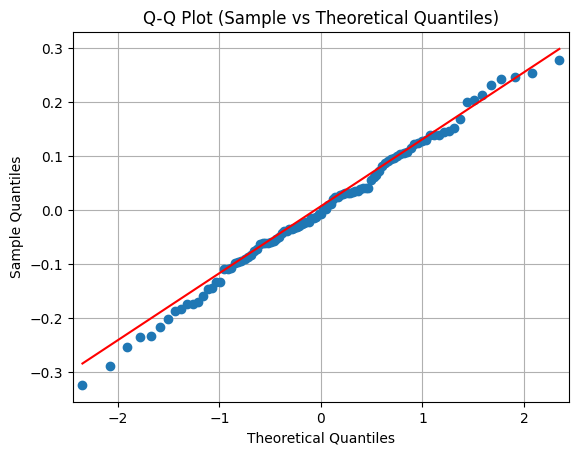

In [21]:
arma11 = ARIMA(dtepts, order=(1,0,1)).fit()
print(arma11.summary())

# Analyze the residuals
resid11 = arma11.resid

# Plot ACF and PACF of the residuals
plot_acf(resid11, lags=20)
plt.show()
plot_pacf(resid11, lags=20)
plt.show()

# Perform the Ljung-Box test for residuals
    # Calculate Ljung-Box test statistics and p-values
ljung_box_results = acorr_ljungbox(resid11, lags=20, return_df=True)
    # Create a plot for the p-values
plt.figure()
plt.plot(ljung_box_results['lb_pvalue'], marker='o', linestyle='-', color='b')
plt.axhline(y=0.05, color='r', linestyle='--')  # 5% significance level
plt.title('Ljung-Box Test P-Values')
plt.xlabel('Lags')
plt.ylabel('P-Value')
plt.xticks(np.arange(0, 21, 1))
plt.xticks(ljung_box_results.index)  # Set x-ticks to all lags
plt.gca().set_xticklabels([str(int(x)) if x % 2 == 0 else '' for x in ljung_box_results.index])
plt.grid()
plt.show()

# Q-Q plot
plt.figure()
sm.qqplot(resid11, line='q', ax=plt.gca())
plt.title('Q-Q Plot (Sample vs Theoretical Quantiles)')
plt.grid()

# Perform the normality test on residuals
normaltest_result = stats.normaltest(resid11)
print("Normality test result:", normaltest_result)

The residual series behaves like a normal white noise, and so the estimated model fits very well to the differenced series data.

### Predict model:

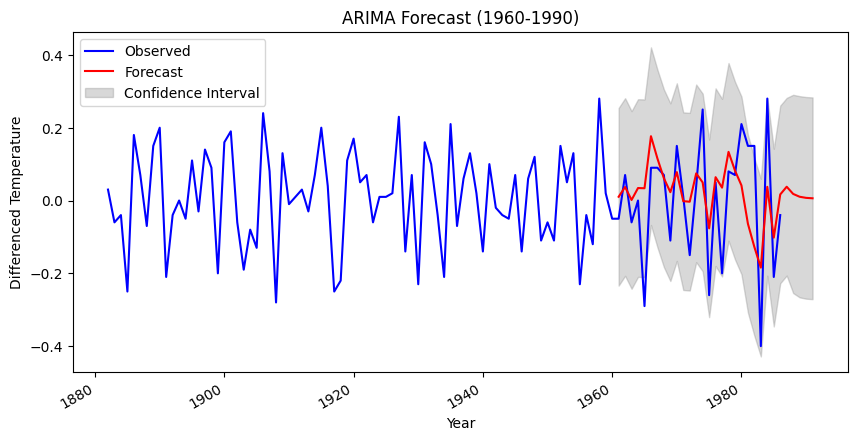

In [22]:
# Generate prediction results
pred = arma11.get_prediction(start='1960-12', end='1990-12')

# Extract predicted mean and confidence intervals
predicts = pred.predicted_mean
predconf = pred.conf_int()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(dtepts, label='Observed', color='blue')
predicts.plot(label='Forecast', color='red')
plt.fill_between(predicts.index,
                 predconf.iloc[:, 0],
                 predconf.iloc[:, 1], color='gray', alpha=0.3, label='Confidence Interval')
plt.title('ARIMA Forecast (1960-1990)')
plt.xlabel('Year')
plt.ylabel('Differenced Temperature')
plt.legend()
plt.show()

The forecasts — both in-sample and out-of-sample — generated by the fitted ARMA(1,1) model are not really satisfactory.

**Exercise:** Fit and predict the ARMA(1,3) model and compare the results to the ARMA(1,3) model.

/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                   dtep   No. Observations:                  105
Model:                 ARIMA(1, 0, 3)   Log Likelihood                  73.779
Date:                Wed, 06 Nov 2024   AIC                           -135.558
Time:                        18:01:57   BIC                           -119.634
Sample:                    12-31-1881   HQIC                          -129.105
                         - 12-31-1985                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0053      0.003      2.103      0.035       0.000       0.010
ar.L1         -0.9615      0.057    -16.813      0.000      -1.074      -0.849
ma.L1          0.5885      0.107      5.480      0.0

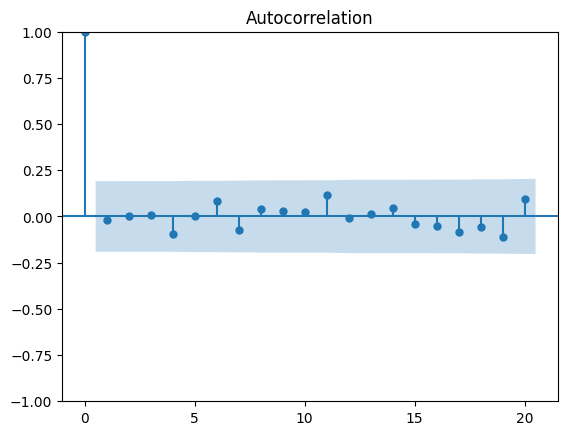

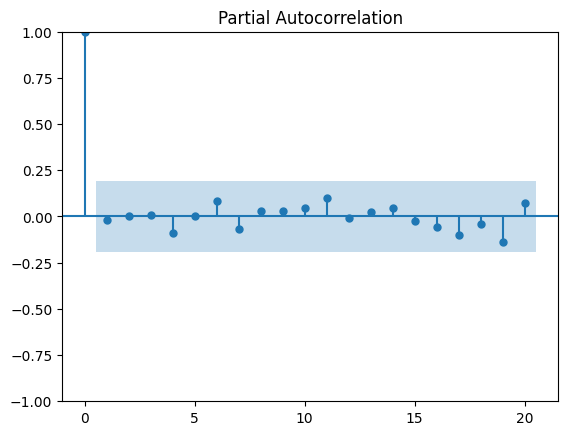

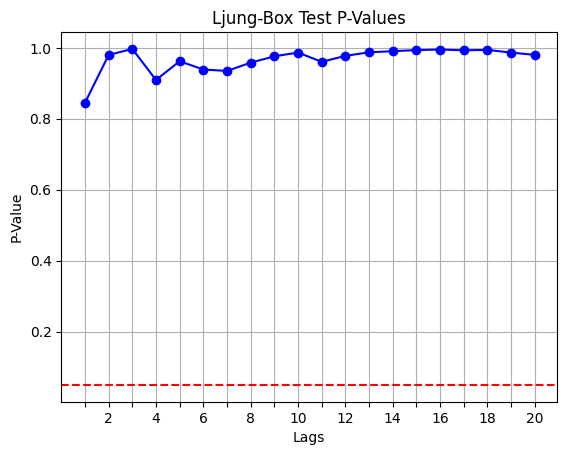

Normality test result: NormaltestResult(statistic=np.float64(0.3330146428631386), pvalue=np.float64(0.8466166184671113))


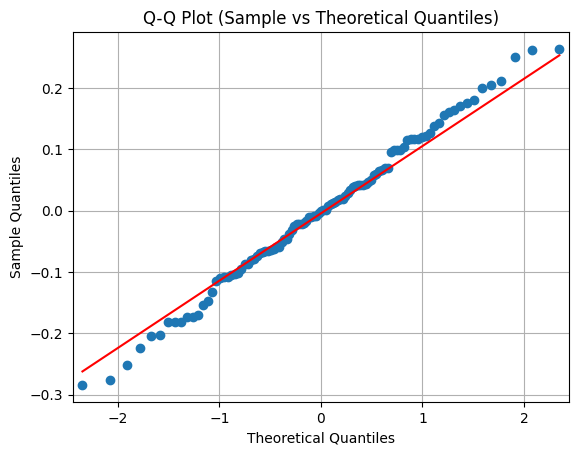

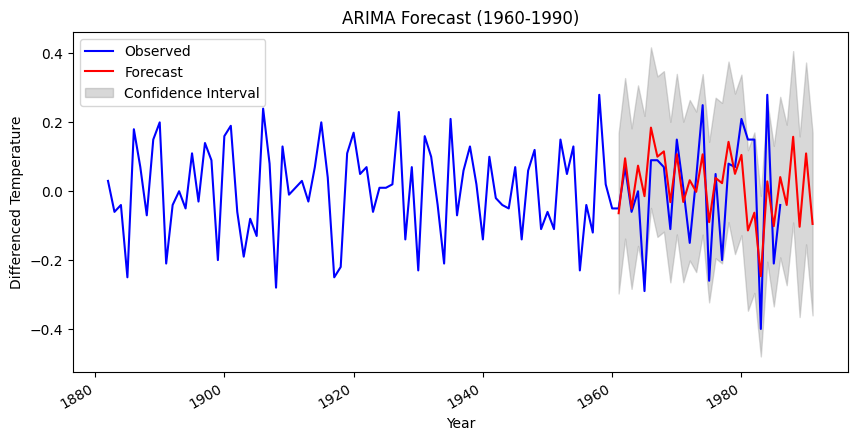

In [23]:
arma13 = ARIMA(dtepts, order=(1,0,3)).fit()
print(arma13.summary())

# Analyze the residuals
resid13 = arma13.resid

# Plot ACF and PACF of the residuals
plot_acf(resid13, lags=20)
plt.show()
plot_pacf(resid13, lags=20)
plt.show()

# Perform the Ljung-Box test for residuals
    # Calculate Ljung-Box test statistics and p-values
ljung_box_results = acorr_ljungbox(resid13, lags=20, return_df=True)
    # Create a plot for the p-values
plt.figure()
plt.plot(ljung_box_results['lb_pvalue'], marker='o', linestyle='-', color='b')
plt.axhline(y=0.05, color='r', linestyle='--')  # 5% significance level
plt.title('Ljung-Box Test P-Values')
plt.xlabel('Lags')
plt.ylabel('P-Value')
plt.xticks(np.arange(0, 21, 1))
plt.xticks(ljung_box_results.index)  # Set x-ticks to all lags
plt.gca().set_xticklabels([str(int(x)) if x % 2 == 0 else '' for x in ljung_box_results.index])
plt.grid()
plt.show()

# Q-Q plot
plt.figure()
sm.qqplot(resid13, line='q', ax=plt.gca())
plt.title('Q-Q Plot (Sample vs Theoretical Quantiles)')
plt.grid()

# Perform the normality test on residuals
normaltest_result = stats.normaltest(resid13)
print("Normality test result:", normaltest_result)

# Generate prediction results
pred = arma13.get_prediction(start='1960-12', end='1990-12')

# Extract predicted mean and confidence intervals
predicts = pred.predicted_mean
predconf = pred.conf_int()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(dtepts, label='Observed', color='blue')
predicts.plot(label='Forecast', color='red')
plt.fill_between(predicts.index,
                 predconf.iloc[:, 0],
                 predconf.iloc[:, 1], color='gray', alpha=0.3, label='Confidence Interval')
plt.title('ARIMA Forecast (1960-1990)')
plt.xlabel('Year')
plt.ylabel('Differenced Temperature')
plt.legend()
plt.show()

Manual differencing versus built-in differencing are two different pre-processing strategies for handling non-stationarity that can lead to different results as the following example demonstrates.

/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


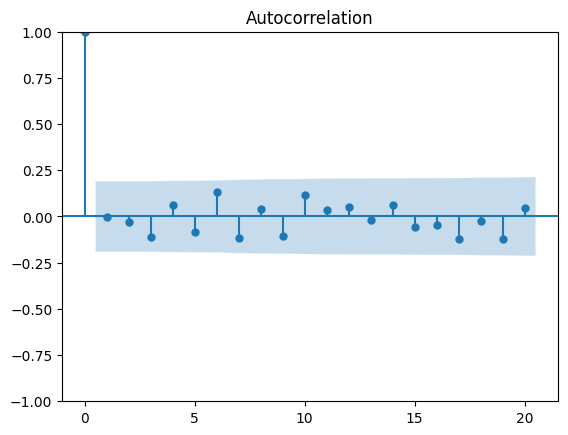

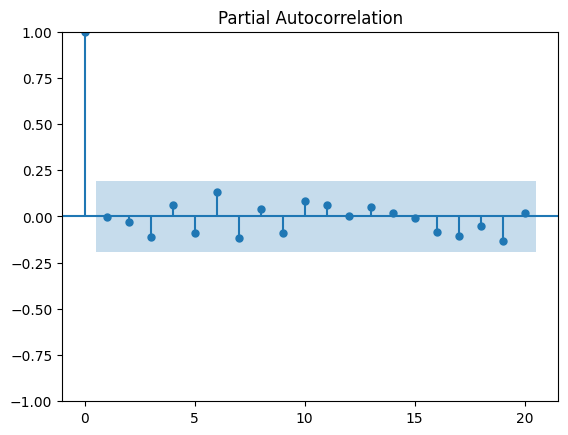

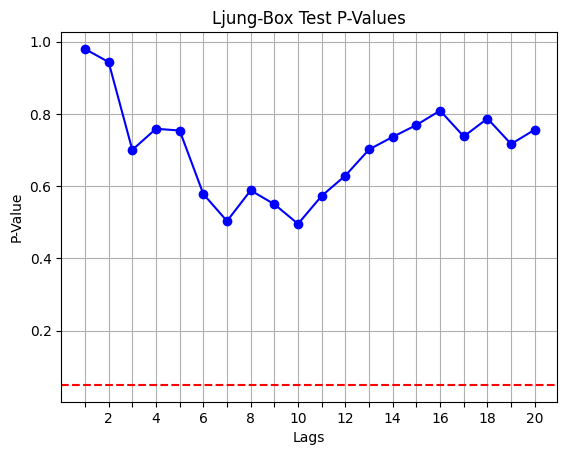

Normality test result: NormaltestResult(statistic=np.float64(2.3252705929891095), pvalue=np.float64(0.3126611394409216))


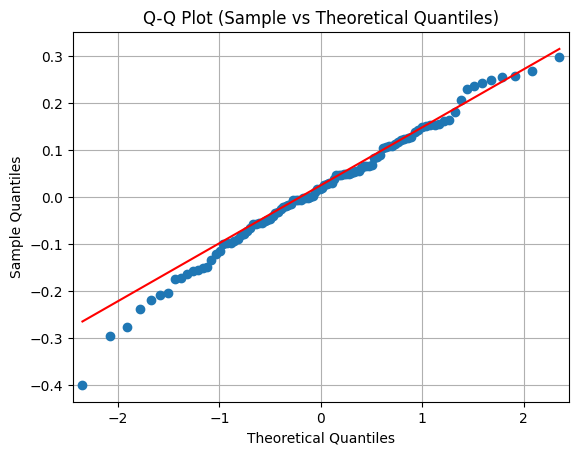

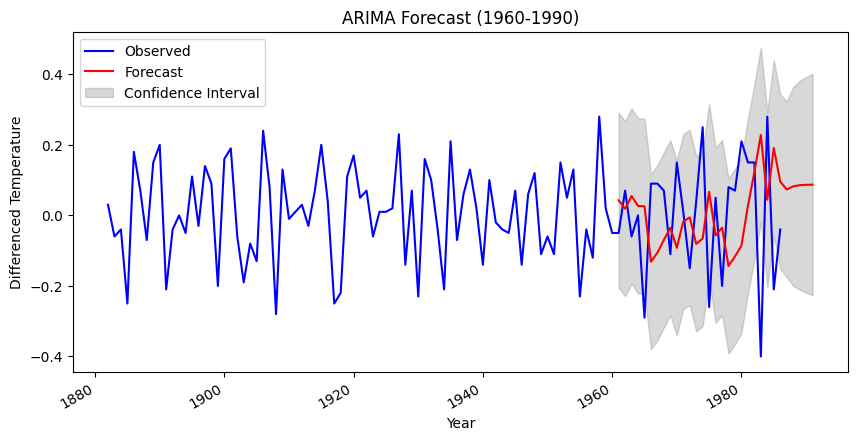

In [24]:
arima111 = ARIMA(tepts, order=(1,1,1)).fit()
resid111 = arima111.resid

# Plot ACF and PACF of the residuals
plot_acf(resid111, lags=20)
plt.show()
plot_pacf(resid111, lags=20)
plt.show()

# Perform the Ljung-Box test for residuals
    # Calculate Ljung-Box test statistics and p-values
ljung_box_results = acorr_ljungbox(resid111, lags=20, return_df=True)
    # Create a plot for the p-values
plt.figure()
plt.plot(ljung_box_results['lb_pvalue'], marker='o', linestyle='-', color='b')
plt.axhline(y=0.05, color='r', linestyle='--')  # 5% significance level
plt.title('Ljung-Box Test P-Values')
plt.xlabel('Lags')
plt.ylabel('P-Value')
plt.xticks(np.arange(0, 21, 1))
plt.xticks(ljung_box_results.index)  # Set x-ticks to all lags
plt.gca().set_xticklabels([str(int(x)) if x % 2 == 0 else '' for x in ljung_box_results.index])
plt.grid()
plt.show()

# Q-Q plot
plt.figure()
sm.qqplot(resid111, line='q', ax=plt.gca())
plt.title('Q-Q Plot (Sample vs Theoretical Quantiles)')
plt.grid()

# Perform the normality test on residuals
normaltest_result = stats.normaltest(resid111)
print("Normality test result:", normaltest_result)

# Generate prediction results
pred = arima111.get_prediction(start='1960-12', end='1990-12')

# Extract predicted mean and confidence intervals
predicts = pred.predicted_mean
predconf = pred.conf_int()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(dtepts, label='Observed', color='blue')
predicts.plot(label='Forecast', color='red')
plt.fill_between(predicts.index,
                 predconf.iloc[:, 0],
                 predconf.iloc[:, 1], color='gray', alpha=0.3, label='Confidence Interval')
plt.title('ARIMA Forecast (1960-1990)')
plt.xlabel('Year')
plt.ylabel('Differenced Temperature')
plt.legend()
plt.show()

Receive both in-sample predictions using `fittedvalues` and out-sample forecasts using `forecast`, directly in the original value scale:

/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/tmp/ipykernel_661/3288196028.py:8: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  forecast_dates = pd.date_range(start=last_date, periods=forecast_steps + 1, freq='A')[1:]


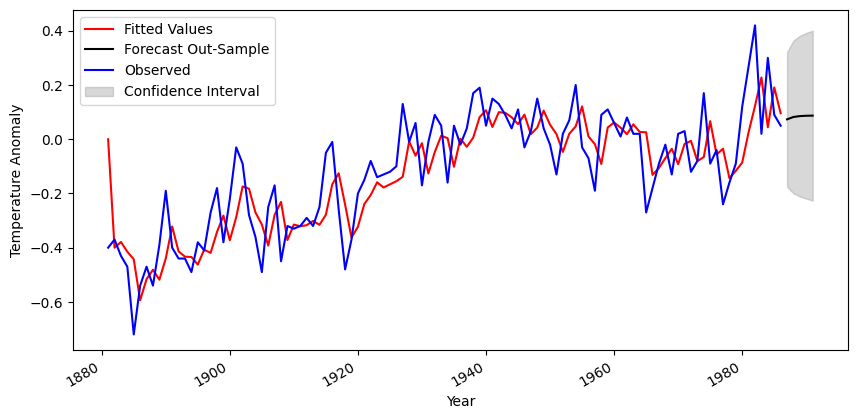

In [25]:
# Fit model
arima111 = ARIMA(tepts, order=(1,1,1)).fit()

# Define out-sample forecast
forecast_steps = 5
forecast_series = arima111.forecast(steps=forecast_steps)
last_date = tepts.index[-1]  # Get the last date of actual data
forecast_dates = pd.date_range(start=last_date, periods=forecast_steps + 1, freq='A')[1:]
forecast_result = arima111.get_forecast(steps=forecast_steps)
forecast_series = forecast_result.predicted_mean
forecast_conf = forecast_result.conf_int()

# Plot
plt.figure(figsize=(10, 5))
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly')
plt.plot(tepts.index, arima111.fittedvalues, color="red", label="Fitted Values")
plt.plot(forecast_dates, forecast_series, color='black', label='Forecast Out-Sample')
tepts.plot(color="blue", label="Observed")
plt.fill_between(forecast_dates,
                 forecast_conf.iloc[:, 0],  # Lower confidence interval
                 forecast_conf.iloc[:, 1],  # Upper confidence interval
                 color='gray', alpha=0.3, label='Confidence Interval')
plt.legend()
plt.show()

/tmp/ipykernel_661/1573191621.py:8: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  forecast_dates = pd.date_range(start=last_date, periods=forecast_steps + 1, freq='A')[1:]


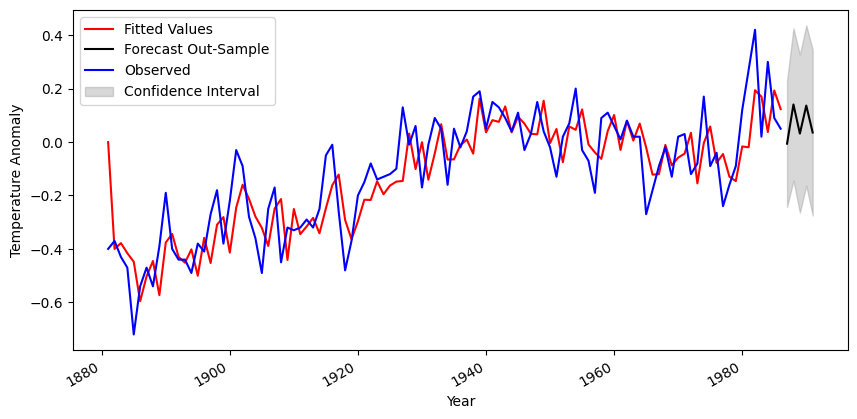

In [26]:
# Fit model
arima113 = ARIMA(tepts, order=(1,1,3)).fit()

# Define out-sample forecast
forecast_steps = 5
forecast_series = arima113.forecast(steps=forecast_steps)
last_date = tepts.index[-1]  # Get the last date of actual data
forecast_dates = pd.date_range(start=last_date, periods=forecast_steps + 1, freq='A')[1:]
forecast_result = arima113.get_forecast(steps=forecast_steps)
forecast_series = forecast_result.predicted_mean
forecast_conf = forecast_result.conf_int()

# Plot
plt.figure(figsize=(10, 5))
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly')
plt.plot(tepts.index, arima113.fittedvalues, color="red", label="Fitted Values")
plt.plot(forecast_dates, forecast_series, color='black', label='Forecast Out-Sample')
tepts.plot(color="blue", label="Observed")
plt.fill_between(forecast_dates,
                 forecast_conf.iloc[:, 0],  # Lower confidence interval
                 forecast_conf.iloc[:, 1],  # Upper confidence interval
                 color='gray', alpha=0.3, label='Confidence Interval')
plt.legend()
plt.show()